In [1]:
# Modules

import numpy as np
import scipy.integrate as spint
import matplotlib.pyplot as plt
#import argparse

from dataclasses import dataclass

from joblib import Parallel, delayed


In [2]:
# Class for the CANN model

class cann_model:
    # define the range of perferred stimuli
    z_min = - np.pi;              
    z_range = 2.0 * np.pi;
    # define the time scale
    tau = 1.0
        
    # function for periodic boundary condition
    def dist(self, c):
        tmp = np.remainder(c, self.z_range)
        
        # routine for numbers
        if isinstance(tmp, (int, float)):
            if tmp > (0.5 * self.z_range):
                return (tmp - self.z_range);
            return tmp;
        
        # routine for numpy arraies
        for tmp_1 in np.nditer(tmp, op_flags=['readwrite']):
            if tmp_1 > (0.5 * self.z_range):
                tmp_1[...] = tmp_1 - self.z_range;
        
        return tmp;
    
    # constructor (?)
    def __init__(self, argument):
        self.k = argument.k;              # rescaled inhibition
        self.beta = argument.beta;        # rescaled STD
        self.beta_f = argument.beta_f;    # flat STD ?
        self.case = argument.case
        self.taud = argument.taud;        # rescaled STD timescale
        self.a = argument.a;              # range of excitatory connection
        self.b = argument.b;              # range of beta modulation
        self.N = argument.N;              # number of units / neurons
        self.dx = self.z_range / self.N     # separation between neurons
        
        # define perferred stimuli for each neuron
        self.x = (np.arange(0,self.N,1)+0.5) * self.dx + self.z_min;
        
        # difference of x's
        self.x_diff = np.array(
                       [[self.dist(self.x[i] - self.x[j]) 
                         for j in range(self.x.shape[0])]
                        for i in range(self.x.shape[0])]
                       )
        
        # calculate the excitatory couple for each pair of neurons
        self.Jxx = np.exp(-0.5 * np.square(
                      self.x_diff / self.a
                   ) ) / (np.sqrt(2*np.pi) * self.a);
                
        self.y = np.zeros((self.N + self.N * self.N));   # initialize dynamical variables
        self.y[self.N:] = 1.0
        
        
        
        if self.beta_f:
            self.beta = argument.beta
        else:
            self.beta = np.zeros_like(self.x_diff)
            
            for i in np.arange(self.Jxx.shape[1]):
                if self.case > 0:
                    gamma_randm = np.random.gamma(shape=3.354520641938138, scale=9.743699331037247, size=self.Jxx.shape[0])
                else:
                    gamma_randm = np.random.gamma(shape=1.377771974410986, scale=29.196273404252505, size=self.Jxx.shape[0])
                    #gamma_randm = np.random.gamma(shape=2.95, scale=(1.40*26.5)/2.95, size=self.Jxx.shape[0])
                    
                J_sort_idx = np.argsort(self.Jxx[:,i])
                gamma_sort_idx = np.argsort(gamma_randm)
                
                for j in np.arange(self.Jxx.shape[0]):
                    self.beta[J_sort_idx[j],i] = gamma_randm[gamma_sort_idx[j]]               
            
            
#            self.beta = 1.0 / (1.0 + np.exp(-np.square(self.x_diff/self.b)))
            self.beta *= argument.beta / np.mean(self.beta)
        
        
        # Here the first N y elements for u(x,t)
        # and the last N*N elements for p(x,x',t)
        
        self.r = np.zeros((self.N));                     # initialize neuronal activities
        self.input = np.zeros((self.N));                 # initialial the external input
    
    # function for setting external iput for each neuron
    def set_input(self, A, z0):
        self.input = \
        A * np.exp(-0.25 * np.square(self.dist(self.x - z0) / self.a));
    
    # function for calculation of neuronal activity of each neuron
    def cal_r_or_u(self, u_in):
        
        if (u_in.shape[0] > self.N):
            u = u_in[:self.N]
        else:
            u = u_in
            
        u0 = 0.5 * (u + np.abs(u));
        r = np.square(u0);
        B = 1.0 + 0.125 * self.k * np.sum(r) * self.dx \
        / (np.sqrt(2*np.pi) * self.a);
        r = r / B;
        
        return r;
    
    # Calculate the centre of mass of u(x,t)
    def cm_of_u(self):
        u = self.y[:self.N]
        max_i = u.argmax()
        cm = np.dot(self.dist(self.x - self.x[max_i]), u) / u.sum()
        cm = cm + self.x[max_i]
        return cm;
    
    # function for calculation of derivatives
    def get_dydt(self, t, y):
        u = y[:self.N]
        p = y[self.N:].reshape((self.N, self.N))
        r = self.cal_r_or_u(u)
        
        dudt = \
            -u + np.dot(self.Jxx* p , r) * self.dx + self.input;
        dudt = dudt / self.tau;
        
        dpdt = (1-p - self.beta * p * r ) / self.taud
        
        dydt = np.append(dudt, dpdt.reshape(-1))
        
        return dydt

In [3]:
# Defining a class of input arguments as a workaround 
# for the argparse

@dataclass()
class argument_c:
    k:float
    beta:float
    beta_f:bool
    case:int
    taud:float
    a:float
    b:float
    N:int
    
    def _init__(self, N, k, beta, beta_f, case, taud, a, b):
        self.N = N
        self.k = k
        self.beta = beta
        self.case = case
        self.beta_f = beta_f
        self.taud = taud
        self.a = a
        self.b = b

In [4]:
np.random.seed(100)

the_beta = 0.0005

arg1 = argument_c(N=128, k=0.5, beta=the_beta, beta_f=False, case=0, taud=50, a=0.5, b=0.1)
the_model1 = cann_model(arg1)

arg2 = argument_c(N=128, k=0.5, beta=the_beta, beta_f=False, case=1, taud=50, a=0.5, b=100)
the_model2 = cann_model(arg2)

In [5]:
# Initialize the system

the_model1.set_input(0.5, 0)
the_model2.set_input(0.5, 0)
out1 = spint.solve_ivp(the_model1.get_dydt, (0, 1000), the_model1.y, method="RK45");
out2 = spint.solve_ivp(the_model2.get_dydt, (0, 1000), the_model2.y, method="RK45");

# update the network state in the CANN object
the_model1.y = out1.y[:,-1]
the_model2.y = out2.y[:,-1]

In [6]:

time_step = 2

the_model1.set_input(0.25, 1.5)
the_model2.set_input(0.25, 1.5)

# take a initial snapshot
snapshots1 = np.array([the_model1.y[:the_model1.N]])
snapshots1_z = [the_model1.cm_of_u()]
snapshots2 = np.array([the_model2.y[:the_model2.N]])
snapshots2_z = [the_model2.cm_of_u()]

# run the simulation and take snapshots every 10 taus
for t in range(0,2000,time_step):
    # decide the period of this step
    t0 = t
    t1 = t + time_step
    # run the simulation and update the state in the CANN object
    out1 = spint.solve_ivp(the_model1.get_dydt, (t0, t1), the_model1.y, method="RK45")
    the_model1.y = out1.y[:,-1]
    out2 = spint.solve_ivp(the_model2.get_dydt, (t0, t1), the_model2.y, method="RK45")
    the_model2.y = out2.y[:,-1]
    # store the snapshot
    snapshots1 = np.append(snapshots1, [the_model1.y[:the_model1.N].transpose()], axis=0)
    snapshots1_z.append(the_model1.cm_of_u())
    snapshots2 = np.append(snapshots2, [the_model2.y[:the_model2.N].transpose()], axis=0)
    snapshots2_z.append(the_model2.cm_of_u())
    

the_model1.set_input(0, 1.5)
the_model2.set_input(0, 1.5)

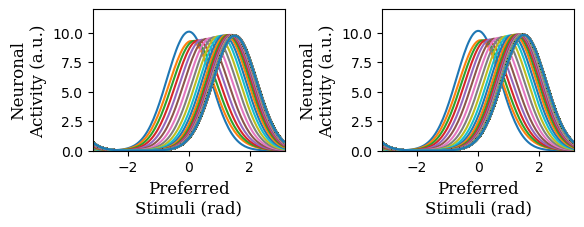

In [7]:
# make a graphic output of the result
out_fig, axs = plt.subplots(1,2,figsize=(15/2.525,6/2.525))

hfont = {'fontname':'Serif'}

# define title and axes' title

for ax in axs:
    ax.set_xlabel('Preferred\nStimuli (rad)', fontsize=12, **hfont)
    ax.set_ylabel('Neuronal\nActivity (a.u.)', fontsize=12, **hfont)
    
    ax.set_xlim((-3.142, 3.142))
    ax.set_ylim((-0.05, 12.0))
    
    # ax.set_xtick(fontsize=14, **hfont)
    # ax.set_ytick(fontsize=14, **hfont)


# plot all the stored snapshots
for i in np.arange(0,snapshots1.shape[0],time_step*2):
    axs[0].plot(the_model1.x, snapshots1[i,:])
for i in np.arange(0,snapshots2.shape[0],time_step*2):
    axs[1].plot(the_model2.x, snapshots2[i,:])

plt.tight_layout()

In [8]:
np.mean(the_model1.beta)

0.0005

(0.0, 150.0)

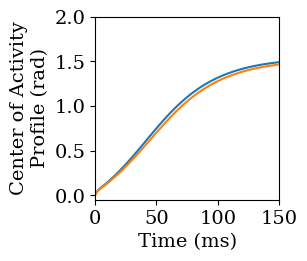

In [9]:
# make a graphic output of the result
out_fig = plt.figure(figsize=(6/2.525,6/2.525))

hfont = {'fontname':'Serif'}

# define title and axes' title
plt.xlabel('Time (ms)', fontsize=14, **hfont)
plt.ylabel('Center of Activity\nProfile (rad)', fontsize=14, **hfont)

plt.xlim((-3.142, 3.142))
plt.ylim((-0.05, 2.0))

plt.xticks(fontsize=14, **hfont)
plt.yticks(np.arange(0,2.4,0.5),fontsize=14, **hfont)

plt.plot(np.arange(len(snapshots1_z))*time_step, snapshots1_z)
plt.plot(np.arange(len(snapshots1_z))*time_step, snapshots2_z)
plt.xlim((0,150))

In [10]:
def one_beta(the_beta_in:float = 0.001, seed:int = 1):

    the_beta = the_beta_in

    rng = np.random.default_rng(seed=seed)
    z0 = rng.uniform(-0.1,0.1)
    z1 = 1.5 + z0
    
    arg1 = argument_c(N=100, k=0.5, beta=the_beta, beta_f=False, case=0, taud=50, a=0.5, b=0.1)
    the_model1_loc = cann_model(arg1)
    
    arg2 = argument_c(N=100, k=0.5, beta=the_beta, beta_f=False, case=1, taud=50, a=0.5, b=100)
    the_model2_loc = cann_model(arg2)
    
    # Initialize the system
    
    the_model1_loc.set_input(0.5, z0)
    the_model2_loc.set_input(0.5, z0)
    out1 = spint.solve_ivp(the_model1_loc.get_dydt, (0, 1000), the_model1_loc.y, method="RK45");
    out2 = spint.solve_ivp(the_model2_loc.get_dydt, (0, 1000), the_model2_loc.y, method="RK45");
    
    # update the network state in the CANN object
    the_model1_loc.y = out1.y[:,-1]
    the_model2_loc.y = out2.y[:,-1]
    
    
    time_step = 5
    
    the_model1_loc.set_input(0.25, z1)
    the_model2_loc.set_input(0.25, z1)
    
    # take a initial snapshot
    snapshots1_loc = np.array([the_model1_loc.y[:the_model1_loc.N]])
    snapshots1_loc_z = [the_model1_loc.cm_of_u()]
    snapshots2_loc = np.array([the_model2_loc.y[:the_model2_loc.N]])
    snapshots2_loc_z = [the_model2_loc.cm_of_u()]
    
    # run the simulation and take snapshots every 10 taus
    for t in range(0,1000,time_step):
        # decide the period of this step
        t0 = t
        t1 = t + time_step
        # run the simulation and update the state in the CANN object
        out1 = spint.solve_ivp(the_model1_loc.get_dydt, (t0, t1), the_model1_loc.y, method="RK45")
        the_model1_loc.y = out1.y[:,-1]
        out2 = spint.solve_ivp(the_model2_loc.get_dydt, (t0, t1), the_model2_loc.y, method="RK45")
        the_model2_loc.y = out2.y[:,-1]
        # store the snapshot
        snapshots1_loc = np.append(snapshots1_loc, [the_model1_loc.y[:the_model1_loc.N].transpose()], axis=0)
        snapshots1_loc_z.append(the_model1_loc.cm_of_u())
        snapshots2_loc = np.append(snapshots2_loc, [the_model2_loc.y[:the_model2_loc.N].transpose()], axis=0)
        snapshots2_loc_z.append(the_model2_loc.cm_of_u())
        
    
    the_model1_loc.set_input(0, z1)
    the_model2_loc.set_input(0, z1)
    
    t1 = np.arange(len(snapshots1_loc_z))[np.array(snapshots1_loc_z) > z1 - the_model1_loc.dx].min()
    t0 = t1 - 1
    
    y1 = snapshots1_loc_z[t1]
    y0 = snapshots1_loc_z[t0]
    
    t_fp = t0 + (1.5 - the_model1_loc.dx - y0) * (t1 - t0) / (y1 - y0) 
    t_fp_1 = time_step * t_fp
        
    t1 = np.arange(len(snapshots2_loc_z))[np.array(snapshots2_loc_z) > z1 - the_model2_loc.dx].min()
    t0 = t1 - 1
    
    y1 = snapshots2_loc_z[t1]
    y0 = snapshots2_loc_z[t0]
    
    t_fp = t0 + (1.5 - the_model2_loc.dx - y0) * (t1 - t0) / (y1 - y0) 
    t_fp_2 = time_step * t_fp
    
    return t_fp_1, t_fp_2

In [11]:
def one_beta_many_sample(the_beta_in):
    result = []
    for t in range(10):
        result.append(one_beta(the_beta_in, t))
    return np.mean(np.array(result), axis = 0)

In [12]:
t_fp = []

# for bete_i in np.arange(0, 0.00201, 0.0001):
#     t_fp.append(one_beta_many_sample(bete_i))

t_fp = Parallel(n_jobs=4)(delayed(one_beta_many_sample)(bete_i) for bete_i in np.arange(0, 0.00201, 0.0001)) 

t_fp = np.array(t_fp)

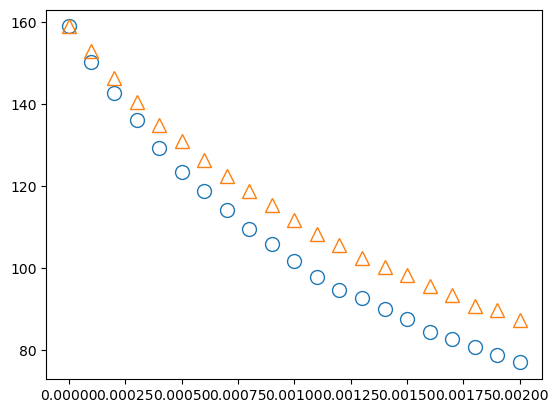

In [13]:
plt.plot(np.arange(0, 0.00201, 0.0001), t_fp[:,0], 'o', ms=10, mfc='none')
plt.plot(np.arange(0, 0.00201, 0.0001), t_fp[:,1], '^', ms=10, mfc='none')

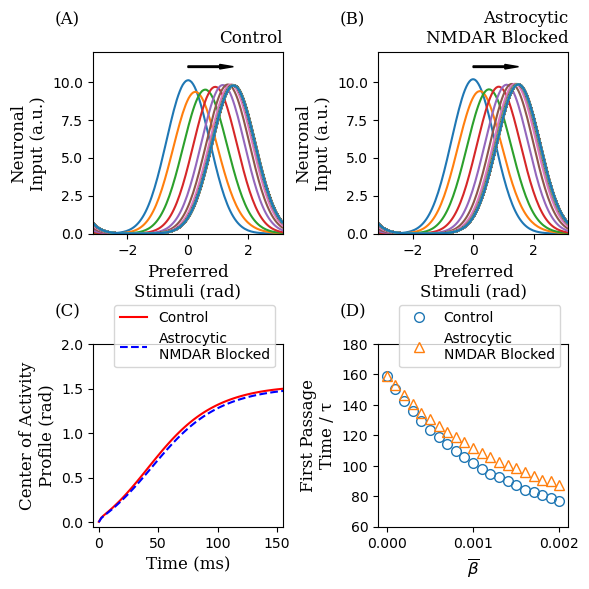

In [14]:
# make a graphic output of the result
out_fig, axs = plt.subplots(2,2,figsize=(15/2.525,15/2.525))

hfont = {'fontname':'Serif'}

# define title and axes' title

for ax in axs[0]:
    ax.set_xlabel('Preferred\nStimuli (rad)', fontsize=12, **hfont)
    ax.set_ylabel('Neuronal\nInput (a.u.)', fontsize=12, **hfont)
    
    ax.set_xlim((-3.142, 3.142))
    ax.set_ylim((-0.05, 12.0))
    


# plot all the stored snapshots
for i in np.arange(0,snapshots1.shape[0],10):
    axs[0,0].plot(the_model1.x, snapshots1[i,:])
for i in np.arange(0,snapshots2.shape[0],10):
    axs[0,1].plot(the_model2.x, snapshots2[i,:])

axs[0,0].arrow(0,11,1.5,0, width=0.1, length_includes_head=True, color="black")
axs[0,1].arrow(0,11,1.5,0, width=0.1, length_includes_head=True, color="black")


# define title and axes' title
axs[1,0].set_xlabel('Time (ms)', fontsize=12, **hfont)
axs[1,0].set_ylabel('Center of Activity\nProfile (rad)', fontsize=12, **hfont)

axs[1,0].set_xlim((-5,155))
axs[1,0].set_ylim((-0.05, 2.0))

axs[1,0].plot(np.arange(len(snapshots1_z))*time_step, snapshots1_z, "r-", label="Control")
axs[1,0].plot(np.arange(len(snapshots1_z))*time_step, snapshots2_z, "b--", label="Astrocytic\nNMDAR Blocked")

axs[1,0].legend(loc="upper left", bbox_to_anchor=(0.075, 1.25))

# define title and axes' title
axs[1,1].set_ylabel("First Passage\nTime / τ", fontsize=12, **hfont)
axs[1,1].set_xlabel(r'$\overline{\beta}$', fontsize=12, **hfont)

axs[1,1].plot(np.arange(0, 0.00201, 0.0001), t_fp[:,0], 'o', ms=7, mfc='none', label="Control")
axs[1,1].plot(np.arange(0, 0.00201, 0.0001), t_fp[:,1], '^', ms=7, mfc='none', label="Astrocytic\nNMDAR Blocked")
axs[1,1].set_ylim((60,180))


axs[1,1].legend(loc="upper left", bbox_to_anchor=(0.075, 1.25))

axs[0,0].text(-0.2,1.15,"(A)", transform=axs[0,0].transAxes, fontsize=12, **hfont)
axs[0,1].text(-0.2,1.15,"(B)", transform=axs[0,1].transAxes, fontsize=12, **hfont)
axs[1,0].text(-0.2,1.15,"(C)", transform=axs[1,0].transAxes, fontsize=12, **hfont)
axs[1,1].text(-0.2,1.15,"(D)", transform=axs[1,1].transAxes, fontsize=12, **hfont)

axs[0,0].text(1.,1.05,"Control", ha="right", transform=axs[0,0].transAxes, fontsize=12, **hfont)
axs[0,1].text(1.,1.05,"Astrocytic\nNMDAR Blocked",ha="right", transform=axs[0,1].transAxes, fontsize=12, **hfont)

# plt.tight_layout(w_pad=0.2, h_pad=0.01)

plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1, hspace=0.6, wspace=0.5)

plt.savefig("Figure_05.pdf")

(0.0, 150.0)

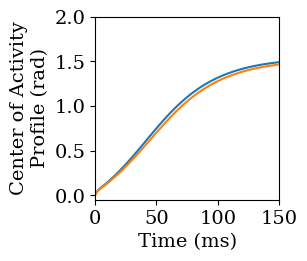

In [15]:
# make a graphic output of the result
out_fig = plt.figure(figsize=(6/2.525,6/2.525))

hfont = {'fontname':'Serif'}

# define title and axes' title
plt.xlabel('Time (ms)', fontsize=14, **hfont)
plt.ylabel('Center of Activity\nProfile (rad)', fontsize=14, **hfont)

plt.xlim((-3.142, 3.142))
plt.ylim((-0.05, 2.0))

plt.xticks(fontsize=14, **hfont)
plt.yticks(np.arange(0,2.4,0.5),fontsize=14, **hfont)

plt.plot(np.arange(len(snapshots1_z))*time_step, snapshots1_z)
plt.plot(np.arange(len(snapshots1_z))*time_step, snapshots2_z)
plt.xlim((0,150))